In [ ]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

In [54]:
# Так как нет желания морочится с сетью, прокину dns-ы
!/bin/bash -c 'echo "nameserver 1.1.1.1 nameserver 1.0.0.1" > /etc/resolv.conf && chattr -f +i /etc/resolv.conf'

In [53]:
# И проверю
!cat /etc/resolv.conf

nameserver 1.1.1.1 nameserver 1.0.0.1


In [51]:
# загрузим сохранения
!/bin/sh -c /workspace/sam2/checkpoints/download_ckpts.sh

--2025-06-24 15:16:11--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_tiny.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.222.236.74, 52.222.236.65, 52.222.236.117, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.222.236.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156008466 (149M) [application/vnd.snesdev-page-table]
Saving to: ‘sam2.1_hiera_tiny.pt’

sam2.1_hiera_tiny.p 100%[===================>] 148.78M  10.4MB/s    in 15s     

2025-06-24 15:16:26 (10.2 MB/s) - ‘sam2.1_hiera_tiny.pt’ saved [156008466/156008466]

--2025-06-24 15:16:26--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.222.236.115, 52.222.236.65, 52.222.236.117, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.222.236.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184416285 (17

In [71]:
!cat /workspace/sam2

cat: /workspace/sam2: Is a directory


In [76]:
!cat /workspace/sam2/sam2/configs/sam2.1/sam2.1_hiera_l.yaml

# @package _global_

# Model
model:
  _target_: sam2.modeling.sam2_base.SAM2Base
  image_encoder:
    _target_: sam2.modeling.backbones.image_encoder.ImageEncoder
    scalp: 1
    trunk:
      _target_: sam2.modeling.backbones.hieradet.Hiera
      embed_dim: 144
      num_heads: 2
      stages: [2, 6, 36, 4]
      global_att_blocks: [23, 33, 43]
      window_pos_embed_bkg_spatial_size: [7, 7]
      window_spec: [8, 4, 16, 8]
    neck:
      _target_: sam2.modeling.backbones.image_encoder.FpnNeck
      position_encoding:
        _target_: sam2.modeling.position_encoding.PositionEmbeddingSine
        num_pos_feats: 256
        normalize: true
        scale: null
        temperature: 10000
      d_model: 256
      backbone_channel_list: [1152, 576, 288, 144]
      fpn_top_down_levels: [2, 3]  # output level 0 and 1 directly use the backbone features
      fpn_interp_model: nearest

  memory_attention:
    _target_: sam2.modeling.memory_attention.MemoryAttention
    d_model: 256
    pos_en

In [75]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "sam2.1_hiera_large.pt"
model_cfg = "/workspace/sam2/sam2/configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

MissingConfigException: Cannot find primary config 'workspace/sam2/sam2/configs/sam2.1/sam2.1_hiera_l.yaml'. Check that it's in your config search path.

Config search path:
	provider=hydra, path=pkg://hydra.conf
	provider=main, path=pkg://sam2
	provider=schema, path=structured://

In [ ]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [ ]:
# Создадим папки под каждое видео
video_folder = '/torch/data'
videos = [i for i in os.listdir(video_folder) if i.endswith('.MOV')]
frames_folders = []
for i in videos:
    os.system(f'mkdir {os.path.join(video_folder, i.replace(".", "_"))}')
    frames_folders.append(i.replace(".", "_"))

In [ ]:
# извлекаем кадры
for i in videos:
    cmd = f"ffmpeg -i {os.path.join(video_folder, i)} -q:v 2 -start_number 0 {os.path.join(video_folder, i.replace('.', '_'))}/'%05d.jpg'"
    os.system(cmd)

In [ ]:
# проверим
!ls -lah /torch/data/1_MOV

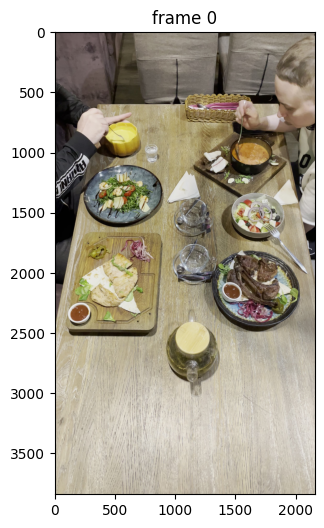

In [20]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = os.path.join(video_folder, frames_folders[0])

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [21]:
inference_state = predictor.init_state(video_path=video_dir)

NameError: name 'predictor' is not defined